# Packages

In [12]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.interpolate import make_interp_spline
from plotnine import *
from matplotlib.colors import to_rgba

# Functions

## Data Cleaning

In [13]:
def parse_filename_components(df_dict):
    """Adds columns for trial number and time range extracted from filenames"""
    for name, df in df_dict.items():
        # Extract components using regular expression
        match = re.match(r'^(\d+)(.*?)_(IMU|MoCap)_(\d+s)_to_(\d+s)$', name)
        
        if match:
            # Add new columns
            df['TrialNumber'] = int(match.group(1))  # First number in filename
            df['TimeRange'] = f"{match.group(4)}-{match.group(5)}"  # Time range
            df['Duration'] = float(match.group(5).replace('s','')) - float(match.group(4).replace('s',''))
        else:
            print(f"Warning: Filename format not recognized for {name}")
            df['TrialNumber'] = None
            df['TimeRange'] = None
            df['Duration'] = None
    
    return df_dict

## Data Manipulation

## Rounding to nearest 0.001s Method

In [14]:
def align_imu_mocap_data(imu_df, mocap_df):
    """
    Aligns IMU and MoCap data by:
    1. Rounding timestamps to the nearest 0.001s.
    2. Aggregating (mean) degree measures at each rounded time.
    3. Merging the two datasets on the rounded timestamps.
    4. Dropping rows with missing values.
    
    Args:
        imu_df: DataFrame containing IMU data.
        mocap_df: DataFrame containing MoCap data.
        
    Returns:
        merged_df: Aligned DataFrame with both IMU and MoCap data.
    """
    # Make copies to avoid modifying originals
    imu = imu_df.copy()
    mocap = mocap_df.copy()
    
    # Round time to nearest 0.01s
    imu['AlignedTime'] = imu['Shifted Time (s)'].round(3)
    mocap['AlignedTime'] = mocap['Time (s)'].round(3)
    
    # Aggregate (mean) degree measures at each rounded time
    imu_agg = imu.groupby('AlignedTime').agg({
        'Angle IMU (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    mocap_agg = mocap.groupby('AlignedTime').agg({
        'Angle MoCap (degrees)': 'mean',
        'TrialNumber': 'first',
        'TimeRange': 'first',
        'Duration': 'first',
        'Device': 'first',
        'Filename': 'first'
    }).reset_index()
    
    # Merge IMU and MoCap data on aligned time
    merged_df = pd.merge(
        imu_agg,
        mocap_agg,
        on=['AlignedTime', 'TrialNumber'],
        suffixes=('_IMU', '_MoCap')
    )
    
    # Drop rows where either IMU or MoCap data is missing
    merged_df = merged_df.dropna()
    
    merged_df = merged_df[['AlignedTime', 
                           'TrialNumber', 
                           'Angle IMU (degrees)', 
                           'Angle MoCap (degrees)', 
                           'Filename_IMU', 
                           'Filename_MoCap']]

    return merged_df

## Common Time Sequence Method

In [15]:
def align_imu_mocap_data_seq(imu_df, mocap_df, time_window=0.005):
    """
    Aligns IMU and MoCap data by resampling to a common time sequence.
    
    Args:
        imu_df: DataFrame containing IMU data.
        mocap_df: DataFrame containing MoCap data.
        time_window: Half-width of the averaging window in seconds.
    
    Returns:
        aligned_df: Combined DataFrame with aligned data.
    """
    # Extract time ranges (should be the same for IMU and MoCap)
    start_time = max(imu_df['Shifted Time (s)'].min(), mocap_df['Time (s)'].min())
    end_time = min(imu_df['Shifted Time (s)'].max(), mocap_df['Time (s)'].max())
    
    # Create common time sequence (e.g., 0.001s intervals)
    common_time = np.arange(start_time, end_time + 0.001, 0.001)
    
    # Initialize arrays to store aligned data
    aligned_imu = np.full_like(common_time, np.nan)
    aligned_mocap = np.full_like(common_time, np.nan)
    
    # Vectorized window calculations
    for i, t in enumerate(common_time):
        # IMU window mask
        imu_mask = (imu_df['Shifted Time (s)'] >= t - time_window) & \
                   (imu_df['Shifted Time (s)'] <= t + time_window)
        # MoCap window mask
        mocap_mask = (mocap_df['Time (s)'] >= t - time_window) & \
                      (mocap_df['Time (s)'] <= t + time_window)
        
        # Calculate means if data exists in window
        if imu_mask.any():
            aligned_imu[i] = imu_df.loc[imu_mask, 'Angle IMU (degrees)'].mean()
        if mocap_mask.any():
            aligned_mocap[i] = mocap_df.loc[mocap_mask, 'Angle MoCap (degrees)'].mean()
    
    # Create mask for valid entries (where both IMU and MoCap have data)
    valid_mask = ~np.isnan(aligned_imu) & ~np.isnan(aligned_mocap)
    
    # Create aligned DataFrame
    aligned_df = pd.DataFrame({
        'AlignedTime': np.round(common_time[valid_mask], 3),
        'TrialNumber': imu_df['TrialNumber'].iloc[0],
        'Angle IMU (degrees)': aligned_imu[valid_mask],
        'Angle MoCap (degrees)': aligned_mocap[valid_mask],
        'Filename_IMU': imu_df['Filename'].iloc[0],
        'Filename_MoCap': mocap_df['Filename'].iloc[0],
    })
    
    return aligned_df

## Visualizations

In [16]:
def plot_all_device_data(aligned_data, motion_name, device_type='IMU'):
    """
    Plot all trials for one device type using ggplot style
    
    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        device_type: 'IMU' or 'MoCap'
    """
    # Combine all trials into one DataFrame
    plot_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime', f'Angle {device_type} (degrees)']].copy()
        temp['Trial'] = f'Trial {trial_num}'
        plot_data.append(temp)
    
    combined = pd.concat(plot_data)
    combined = combined.rename(columns={
        'AlignedTime': 'Time',
        f'Angle {device_type} (degrees)': 'Angle'
    })
    
    plot = (
        ggplot(combined, aes(x='Time', y='Angle', color='Trial')) +
        geom_line(size=1, alpha=0.7) +
        labs(
            title=f'{motion_name} - All {device_type} Trials',
            x='Aligned Time (s)',
            y='Angle (degrees)'
        ) +
        theme_bw() +
        theme(
            figure_size=(12, 6),
            legend_position='right',
            legend_title=element_blank()
        )
    )
    return plot

def plot_differences_gg(aligned_data, motion_name, smooth=True):
    """
    Difference plot using ggplot-style with geom_smooth()

    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        smooth: Add an overall smoothing spline
    """
    # Prepare difference data
    diff_data = []
    for trial_num, df in aligned_data.items():
        temp = df[['AlignedTime']].copy()
        temp['Difference'] = df['Angle MoCap (degrees)'] - df['Angle IMU (degrees)']
        temp['Trial'] = f'Trial {trial_num}'
        diff_data.append(temp)
    
    combined = pd.concat(diff_data)
    
    # Base plot
    plot = (
        ggplot(combined, aes(x='AlignedTime', y='Difference')) +
        geom_hline(yintercept=0, linetype='dashed', color='gray', alpha=0.5) +
        labs(
            title=f'{motion_name} - MoCap vs IMU Differences',
            x='Aligned Time (s)',
            y='Difference (degrees)'
        ) +
        theme_bw() +
        theme(figure_size=(12, 6))
    )
    
    if not smooth:
        # Individual trial lines with colors
        plot += geom_line(aes(color='Trial'), size=.85, alpha=0.5)
    else:
        # Faint individual lines
        plot += geom_line(aes(group='Trial'), color='gray', size=.85, alpha=0.15)
    
    if smooth:
        plot += geom_smooth(
            aes(group=1),  # Treat all data as one group
            method='loess',
            color='red',
            size=1.5,
            alpha=0.8,
            span=0.3,  # Controls smoothness (0-1; 1 = most smooth)
            se = False
        )
    
    return plot

def plot_single_trial_comparison_gg(aligned_data, motion_name, trial_num, gap_threshold=0.01):
    """
    Single trial comparison plot with gaps for missing time values
    
    Args:
        aligned_data: Dictionary of aligned DataFrames
        motion_name: Name of the motion
        trial_num: Trial number to plot
        gap_threshold: Time difference (in seconds) that constitutes a gap
    """
    if trial_num not in aligned_data:
        raise ValueError(f"Trial {trial_num} not found")
    
    df = aligned_data[trial_num].copy()
    
    # Add gap indicators
    df = df.sort_values('AlignedTime')
    df['time_diff'] = df['AlignedTime'].diff()
    df['new_group'] = (df['time_diff'] > gap_threshold).cumsum()
    df['Difference'] = df['Angle MoCap (degrees)'] - df['Angle IMU (degrees)']
    
    # Main comparison plot with gaps
    comparison_plot = (
        ggplot(df, aes(x='AlignedTime')) +
        geom_line(aes(y='Angle IMU (degrees)', color='"IMU"', group='new_group'), size=.85) +
        geom_line(aes(y='Angle MoCap (degrees)', color='"MoCap"', group='new_group'), size=.85) +
        labs(
            title=f'{motion_name} - Trial {trial_num}',
            color='Device',
            x='Aligned Time (s)',
            y='Angle (degrees)' 
            ) +
        scale_color_manual(values=["blue", "green"]) +
        theme_bw()
    )
    
    return comparison_plot

# Data Read-in

In [17]:
# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
axial_rotation = {}
flexion = {}
lateral_bending = {}

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in all_files:
    try:
        # Get the filename without path or extension
        filename = os.path.splitext(os.path.basename(file))[0]
        
        # Read the CSV file
        df = pd.read_csv(file)

        # Add source column (IMU or MoCap)
        if 'IMU' in filename.upper():
            df['Device'] = 'IMU'
        elif 'MOCAP' in filename.upper():
            df['Device'] = 'MoCap'
        else:
            df['Device'] = 'Unknown'
            print(f"Warning: Couldn't determine source for {filename}")
        
        # Add filename as a column for reference
        df['Filename'] = filename 
        
        # Categorize based on filename
        if 'AxialRotation' in filename:
            axial_rotation[filename] = df
        elif 'Flexion' in filename:
            flexion[filename] = df
        elif 'LateralBending' in filename:
            lateral_bending[filename] = df
        else:
            print(f"File {filename} didn't match any category")
            
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"Loaded {len(axial_rotation)} AxialRotation files")
print(f"Loaded {len(flexion)} Flexion files")
print(f"Loaded {len(lateral_bending)} LateralBending files")

Loaded 52 AxialRotation files
Loaded 56 Flexion files
Loaded 54 LateralBending files


In [18]:
axial_rotation = parse_filename_components(axial_rotation)
flexion = parse_filename_components(flexion)
lateral_bending = parse_filename_components(lateral_bending)

# Time Matching

In [19]:
def process_motion(motion_dict, angle_col_name):
    """
    Processes a motion dictionary to align IMU/MoCap pairs with exact trial number matching.
    
    Args:
        motion_dict: Dictionary of DataFrames (axial_rotation, flexion, etc.)
        angle_col_name: Name of the angle column (e.g., 'AxialRotation Angle')
        
    Returns:
        Dictionary of aligned DataFrames keyed by trial number
    """
    aligned_data = {}
    
    # Create a lookup dictionary {trial_num: {device: df}}
    trial_lookup = {}
    for name, df in motion_dict.items():
        trial_num = df['TrialNumber'].iloc[0]
        device = 'IMU' if 'IMU' in name else 'MoCap'
        
        if trial_num not in trial_lookup:
            trial_lookup[trial_num] = {}
        trial_lookup[trial_num][device] = df
    
    # Process each trial
    for trial_num, devices in trial_lookup.items():
        try:
            if 'IMU' in devices and 'MoCap' in devices:
                # Standardize column names
                imu_df = devices['IMU'].rename(
                    columns={f'{angle_col_name} Angle IMU (degrees)': 'Angle IMU (degrees)'})
                mocap_df = devices['MoCap'].rename(
                    columns={f'{angle_col_name} Angle MoCap (degrees)': 'Angle MoCap (degrees)'})
                
                # Align data (uncommment desired method)
                # aligned_df = align_imu_mocap_data(imu_df, mocap_df)
                aligned_df = align_imu_mocap_data_seq(imu_df, mocap_df)
            
                aligned_data[trial_num] = aligned_df
            else:
                print(f"Trial {trial_num} missing {'IMU' if 'IMU' not in devices else 'MoCap'} data")
                
        except Exception as e:
            print(f"Error processing trial {trial_num}: {str(e)}")
    
    return aligned_data

# Process all motion types
# aligned_axial = process_motion(axial_rotation, 'AxialRotation')
# aligned_flexion = process_motion(flexion, 'Flexion')
# aligned_lateral = process_motion(lateral_bending, 'LateralBending')

### Save Aligned Data

In [20]:
# for trial_num, df in aligned_axial.items():
#     df.to_csv(f"Modified Aligned Data All Participants/axial_rotation_trial_{trial_num}.csv", index=False)

# for trial_num, df in aligned_flexion.items():
#     df.to_csv(f"Modified Aligned Data All Participants/flexion_trial_{trial_num}.csv", index=False)

# for trial_num, df in aligned_lateral.items():
#     df.to_csv(f"Modified Aligned Data All Participants/lateral_trial_{trial_num}.csv", index=False)

### Load Aligned Data

In [ ]:
def load_aligned_data_from_csv(directory="Modified Aligned Data All Participants"):
    """
    Loads saved CSV files and reconstructs the original dictionary structure:
    {
        'axial_rotation': {trial_num: df, ...},
        'flexion': {trial_num: df, ...},
        'lateral_bending': {trial_num: df, ...}
    }
    """
    aligned_data = {
        'axial_rotation': {},
        'flexion': {},
        'lateral_bending': {}
    }
    
    # Map filename prefixes to dictionary keys
    file_key_mapping = {
        'axial_rotation': 'axial_rotation',
        'flexion': 'flexion',
        'lateral': 'lateral_bending'  # Adjust if filenames differ
    }
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Extract motion type and trial number
            parts = filename.split('_')
            motion_type = parts[0]  # 'axial', 'flexion', 'lateral'
            trial_num = int(parts[-1].replace('.csv', '').split('_')[-1])
            
            # Find the correct dictionary key
            for key in file_key_mapping:
                if key in filename:
                    aligned_key = file_key_mapping[key]
                    break
            else:
                continue  # Skip unrecognized files
            
            # Load CSV and store in dictionary
            df = pd.read_csv(os.path.join(directory, filename))
            aligned_data[aligned_key][trial_num] = df
    
    return aligned_data

# Load all data
reconstructed_data = load_aligned_data_from_csv()

# Access like before:
aligned_axial = reconstructed_data['axial_rotation']
aligned_flexion = reconstructed_data['flexion']
aligned_lateral = reconstructed_data['lateral_bending']

# Visualizations

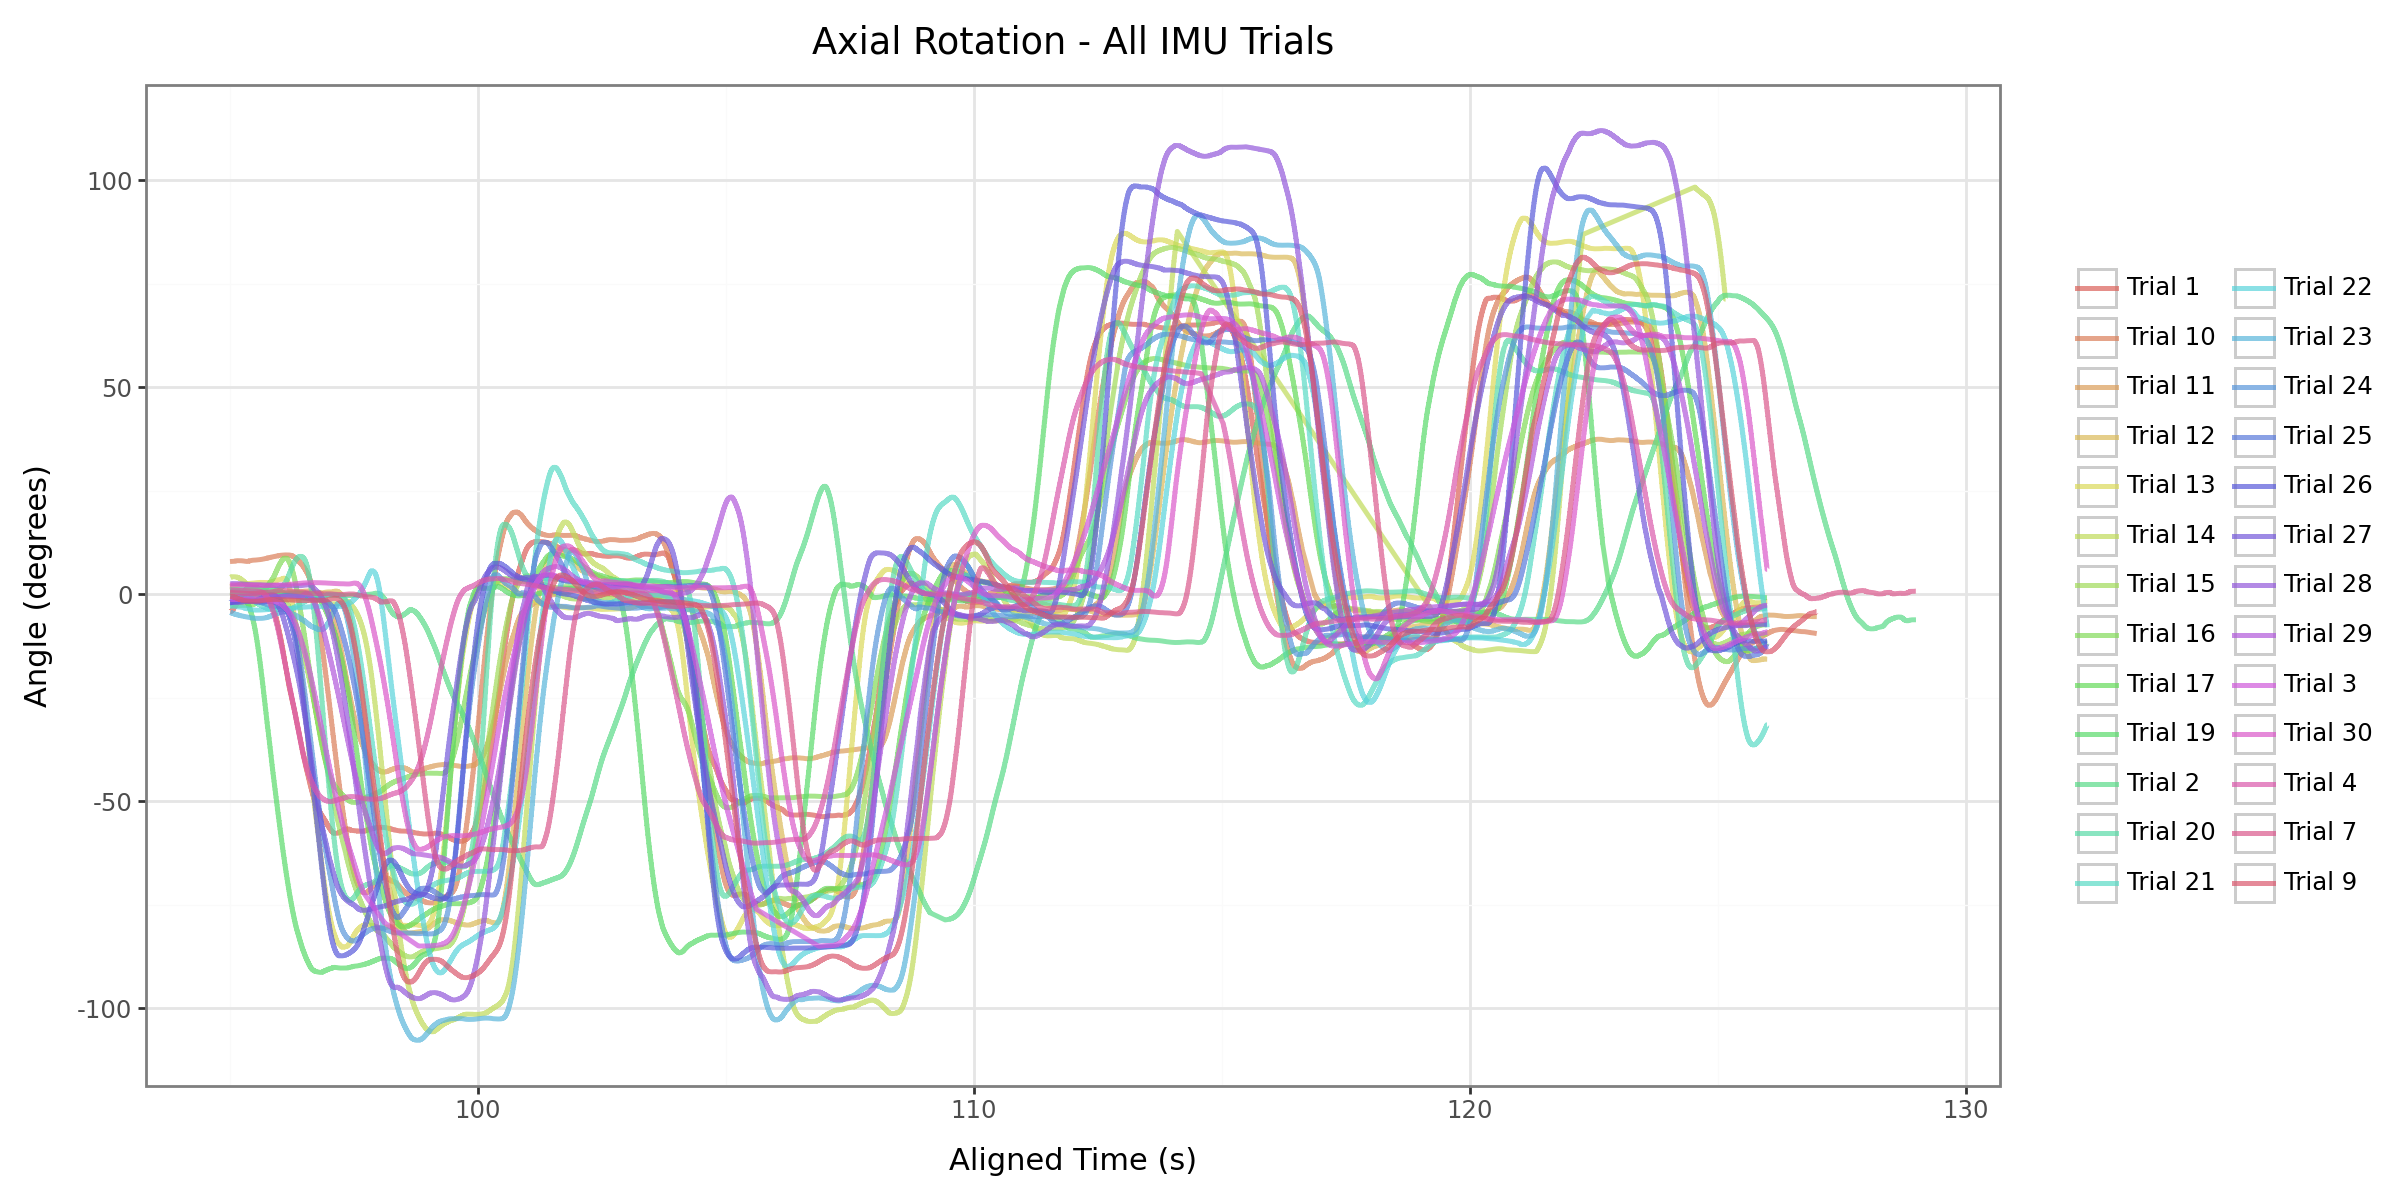

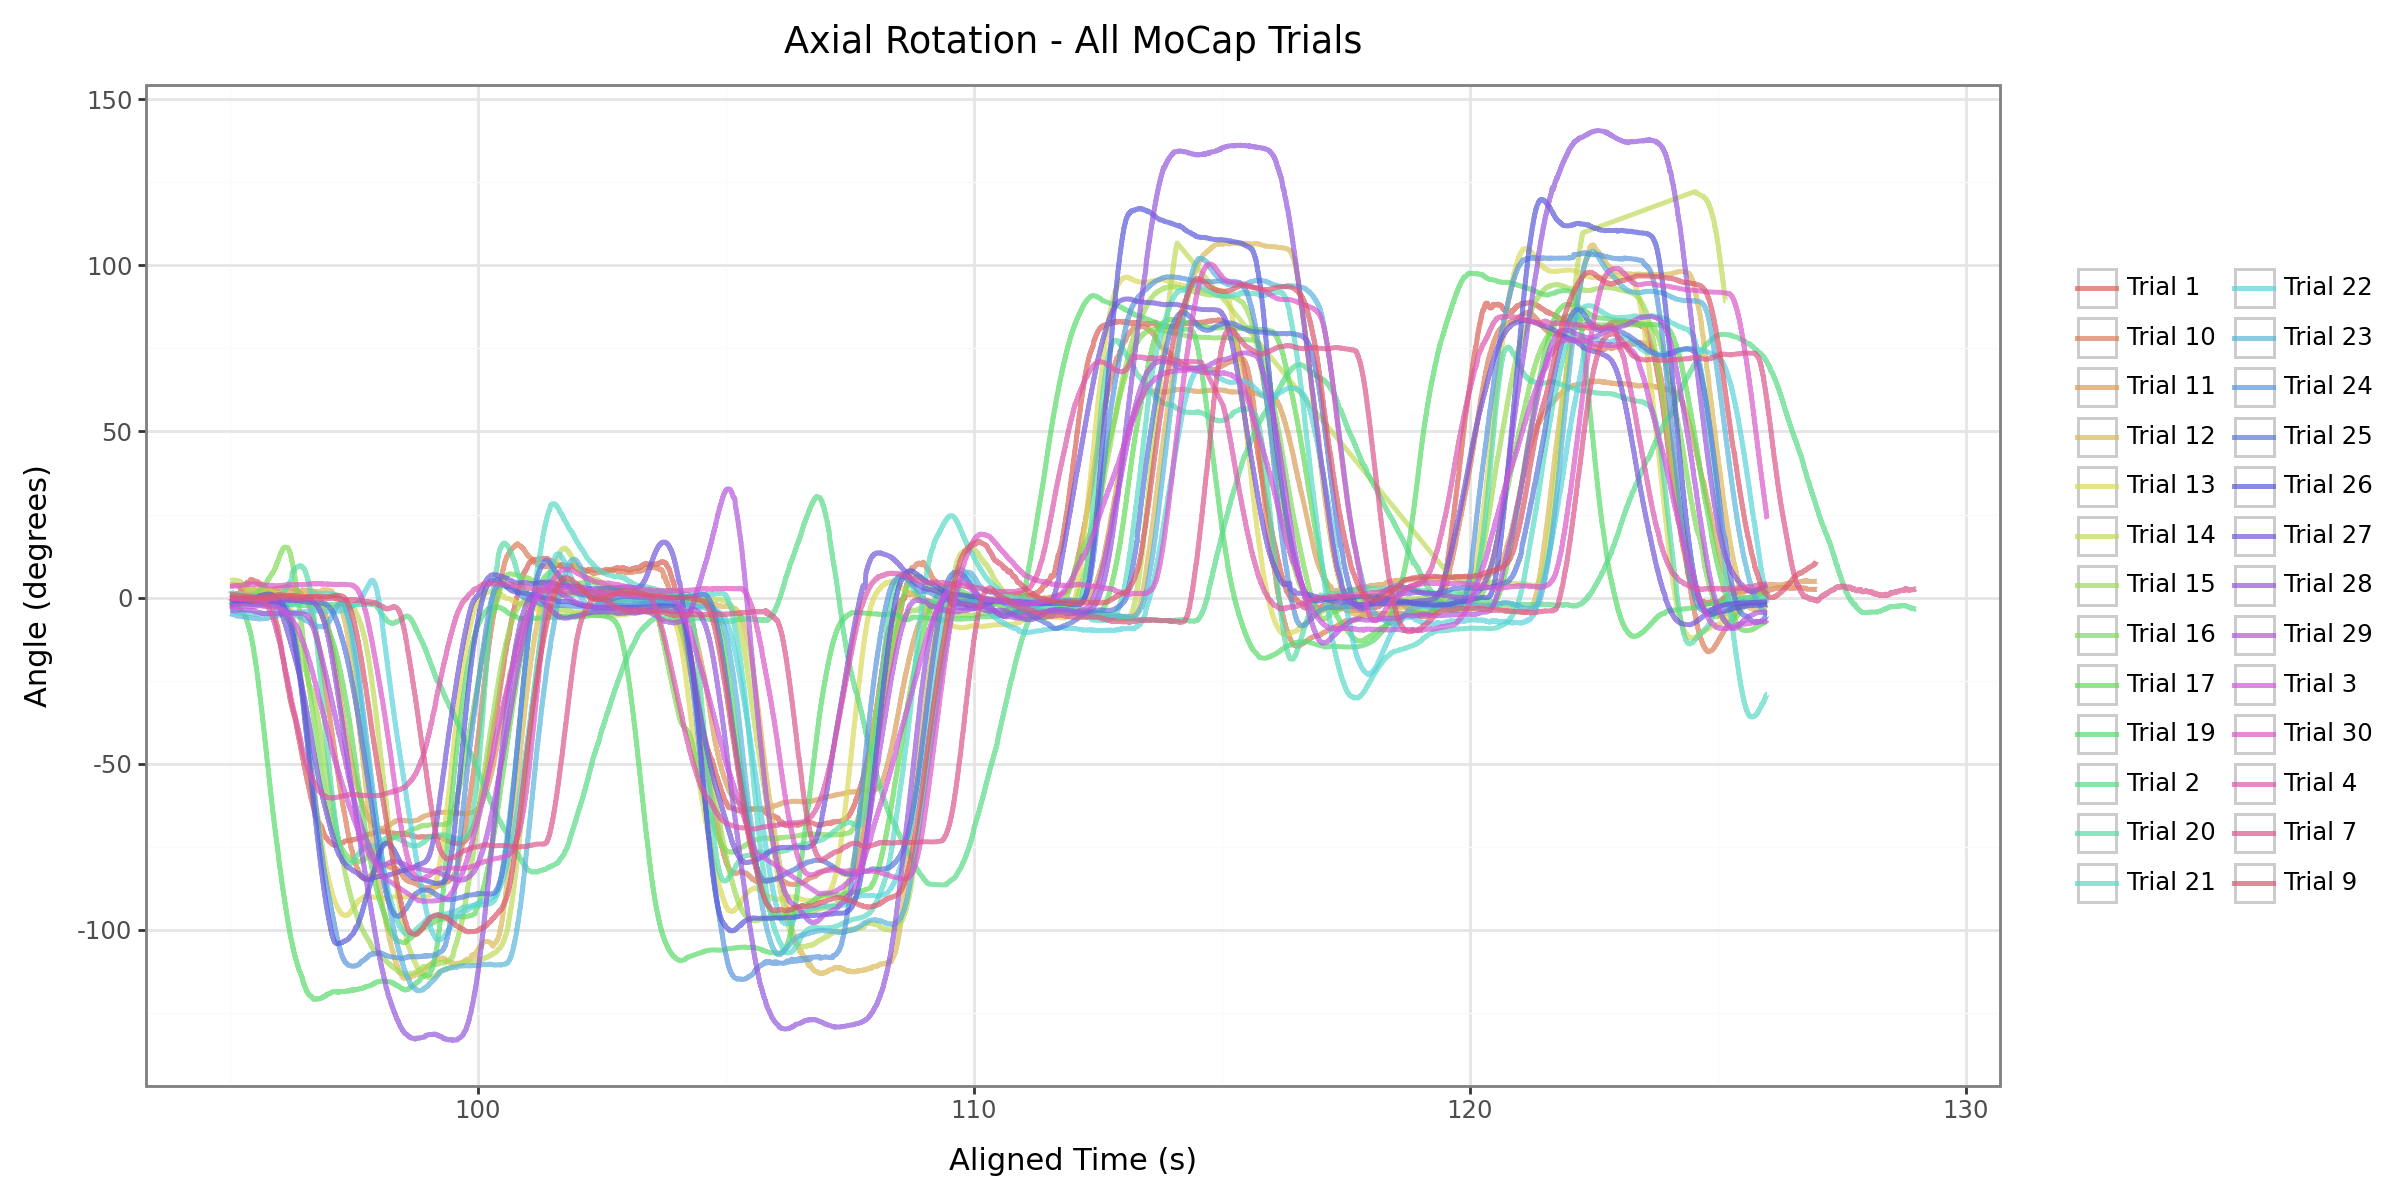

In [22]:
p = plot_all_device_data(aligned_axial, 'Axial Rotation', 'IMU')
p.show()

p = plot_all_device_data(aligned_axial, 'Axial Rotation', 'MoCap')
p.show()

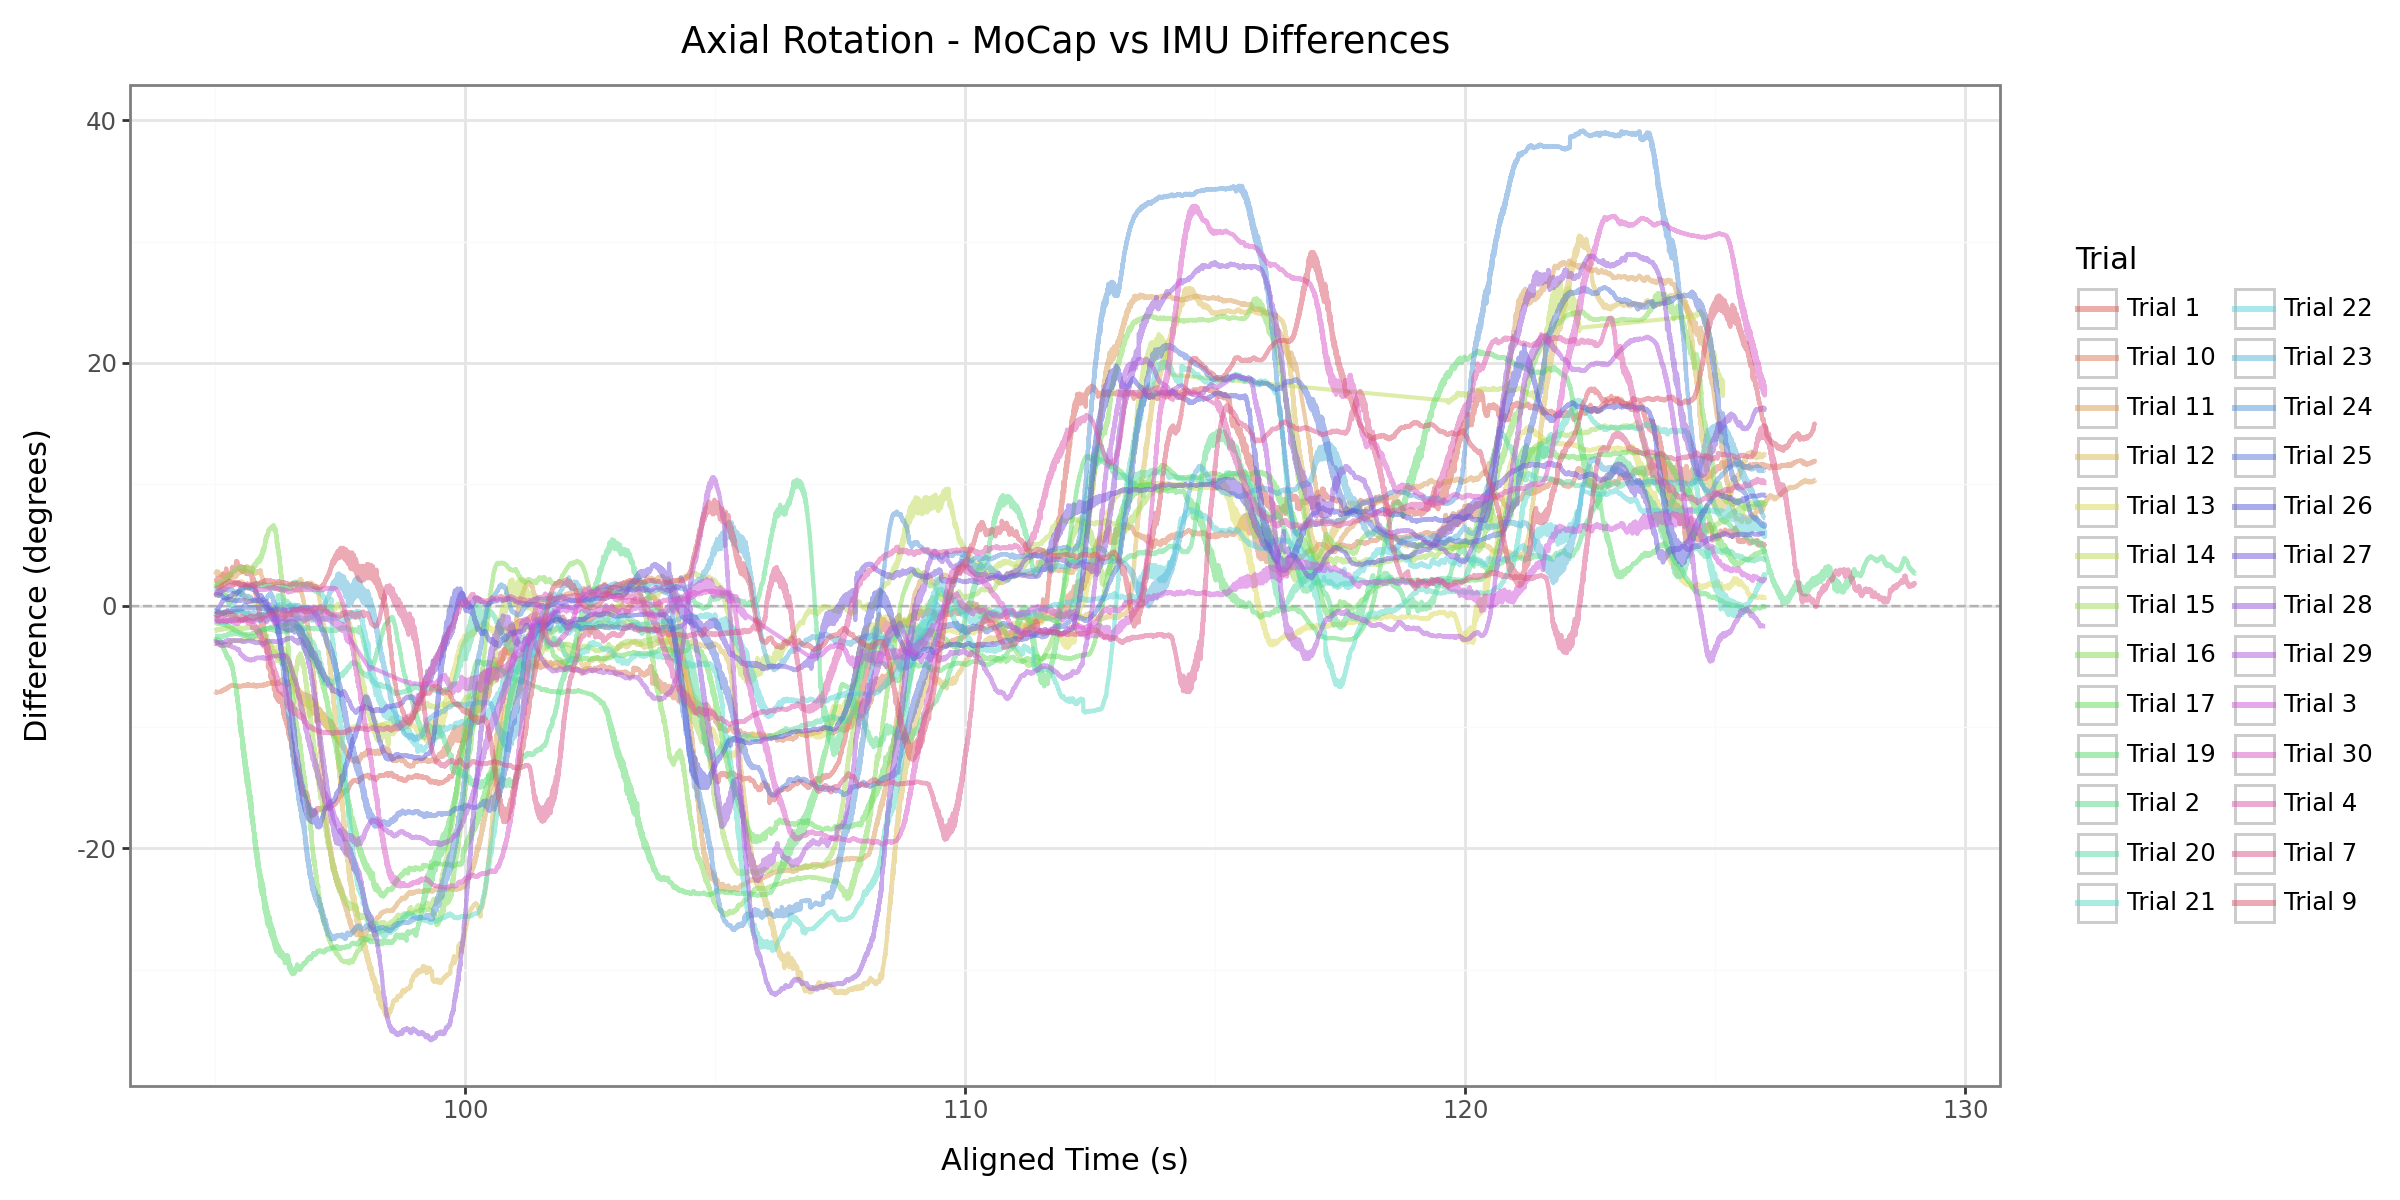

In [ ]:
# Plot differences with LOESS smoothing
p = plot_differences_gg(aligned_axial, 'Axial Rotation', smooth=False)
p.show()

p = plot_differences_gg(aligned_axial, 'Axial Rotation', smooth=True)
p.show()

p = plot_differences_gg(aligned_flexion, 'Flexion', smooth=True)
p.show()

p = plot_differences_gg(aligned_lateral, 'Lateral', smooth=True)
p.show()

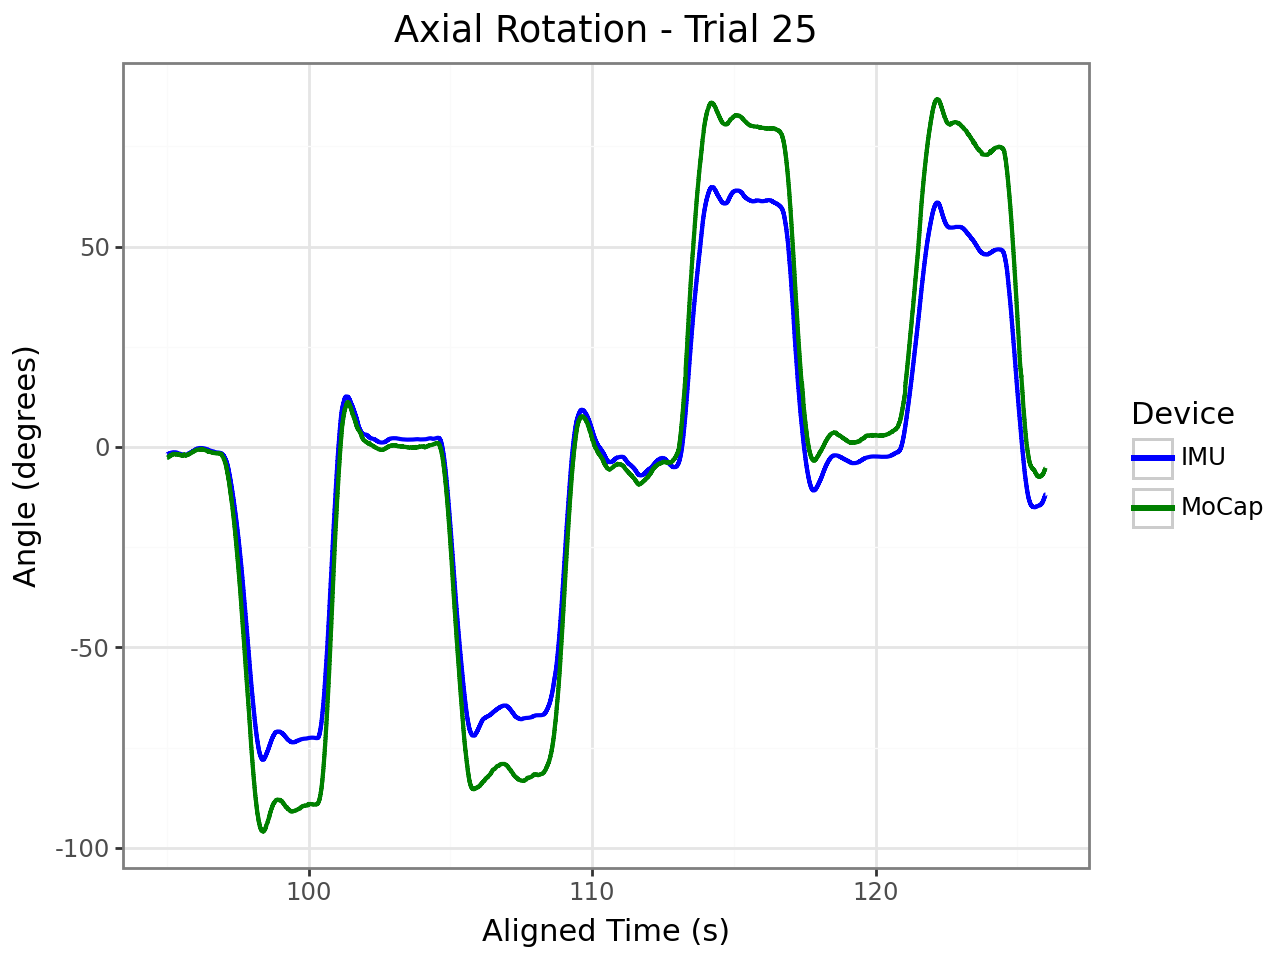

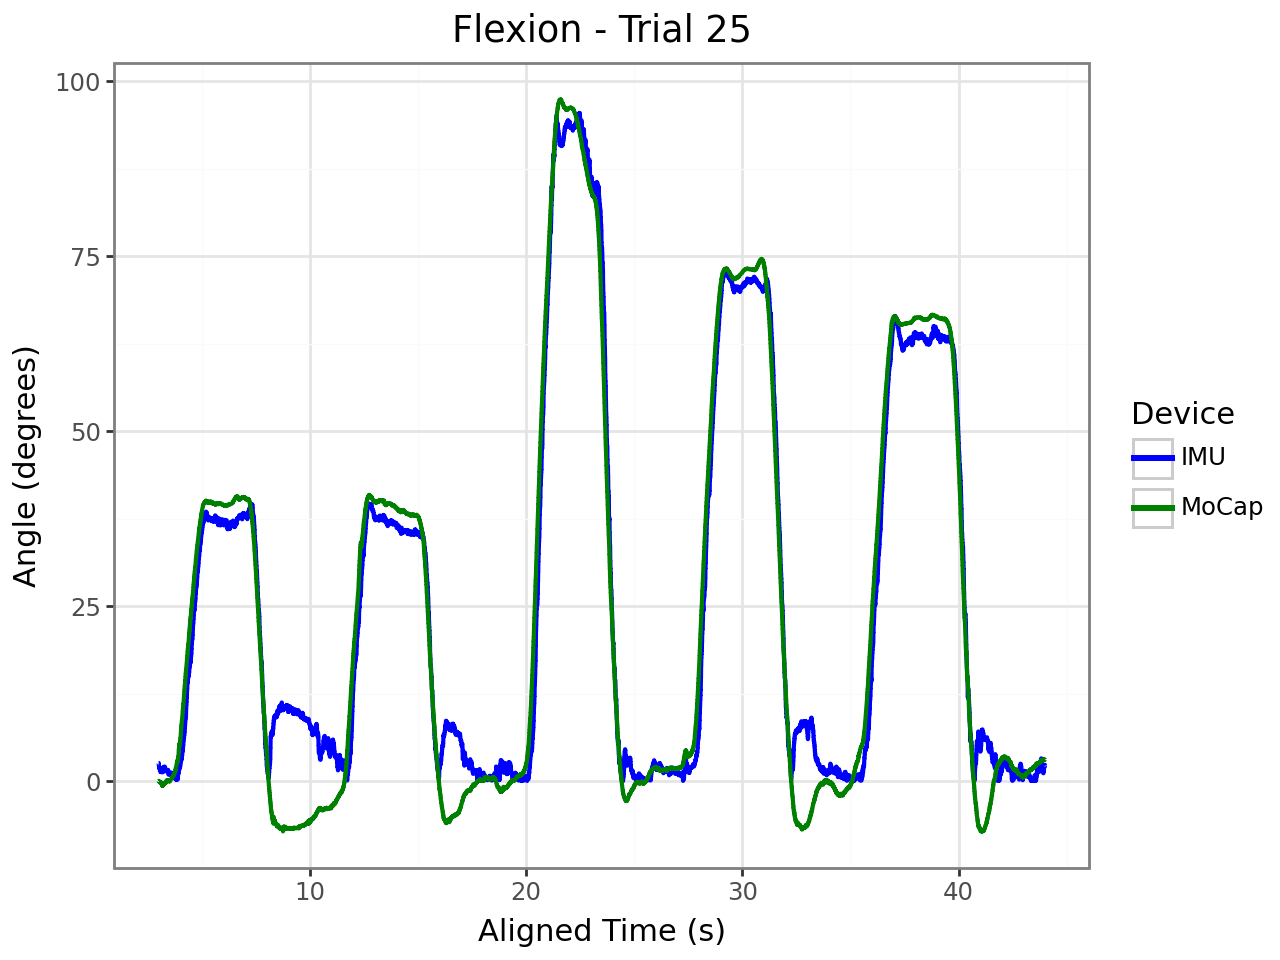

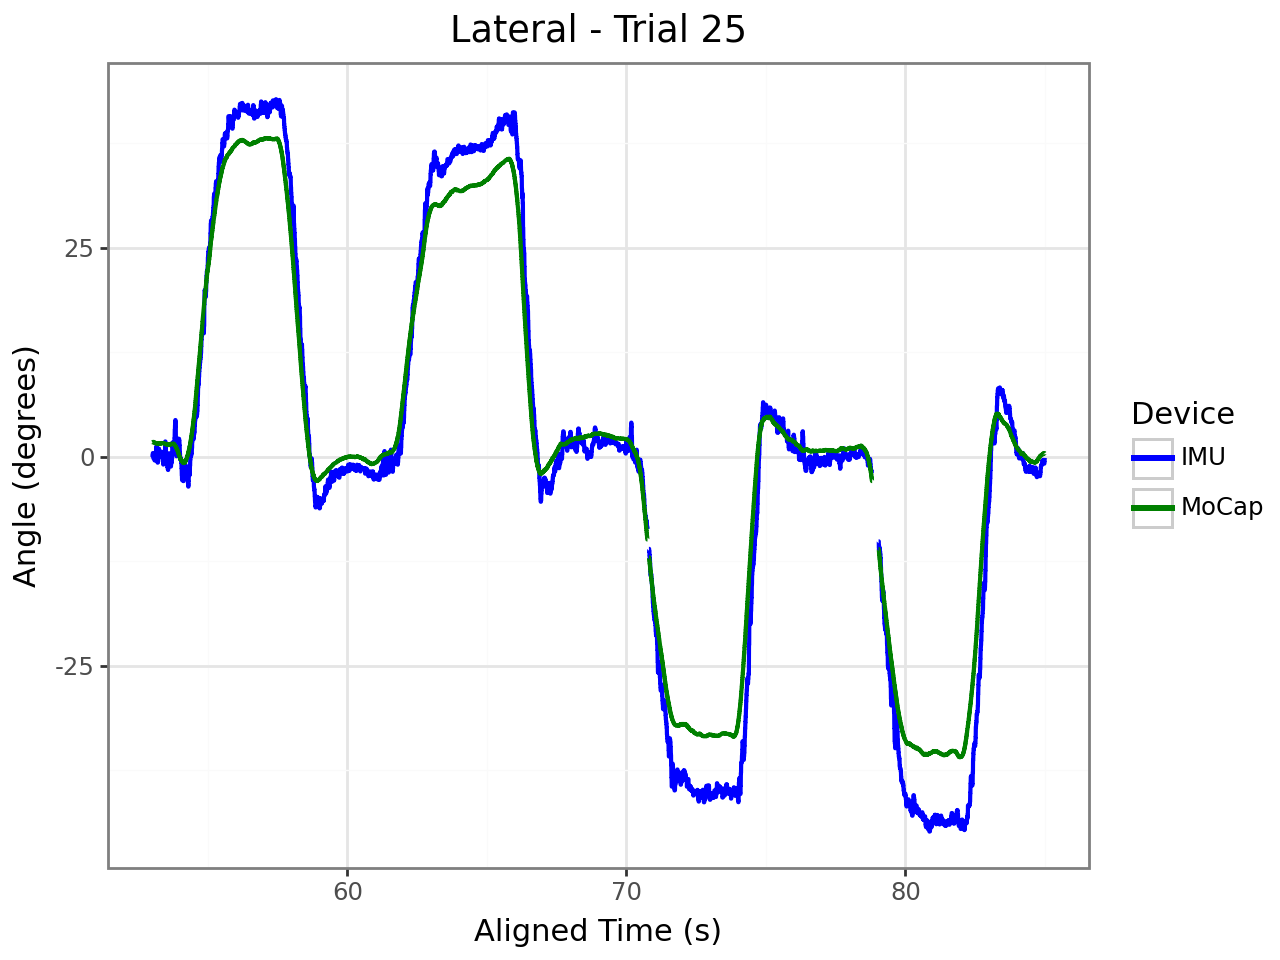

In [ ]:
# Single trial plot
p = plot_single_trial_comparison_gg(aligned_axial, 'Axial Rotation', 25)
p.show()

p = plot_single_trial_comparison_gg(aligned_flexion, 'Flexion', 25)
p.show()

p = plot_single_trial_comparison_gg(aligned_lateral, 'Lateral', 25)
p.show()